<img src='https://wallpaperaccess.com/full/471490.jpg' />


---


# Greek Hedging

W tym notebooku zaprezentujemy:
* Jaka jest intuicja za greckimi parametrami?
* Co stoi za zmianą cen instrumentu pochodnego?
* Jak możemy użyć tej wiedzy do zabezpieczenia pozycji?

---

## Setup

### Biblioteki

In [1]:
!pip install mibian
!pip install yfinance
!pip install dash
!pip install jupyter-dash
!pip install --upgrade matplotlib

In [94]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d
import scipy.stats as sc
from scipy.stats import norm
from IPython.core.debugger import Pdb
from IPython.display import HTML
import mibian
import yfinance as yf
from tqdm import tqdm
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import dash
from dash import dcc
from dash import html
import plotly.express as px
from jupyter_dash import JupyterDash
import pandas as pd

plt.style.use('seaborn')
colorscale = 'rdbu'

%matplotlib notebook

### Geometryczny ruch Browna

Jako model cen akcji przyjmujemy GBM, poniżej przykładowa funkcja generująca wybraną liczbę trajektorii przy zadanych parametrach

In [6]:
def gbm(S0: float, r: float, sigma: float, T: float, time_steps: int, n_paths: int, 
        random_generator = sc.norm(0, 1)):
    """
    Generate Geometric Brownian Motion paths
    :param S0: float, starting price
    :param r: float, risk free rate
    :param sigma: float, volatility
    :param T: float, time horizon
    :param time_steps: int, how many subintervals include from 0 to T
    :param n_paths: int, how many paths to simulate
    :param random_generator: distribution family from which to draw random increments
    :return: paths: ndarray, simulated paths
    """
    
    dt = float(T) / time_steps
    paths = np.zeros((time_steps + 1, n_paths), np.float64)
    paths[0] = S0
    for t in range(1, time_steps + 1):
        rand = random_generator.rvs(size = n_paths)
        paths[t] = paths[t - 1] * np.exp((r - 0.5 * sigma ** 2) * dt +
                                         sigma * np.sqrt(dt) * rand)
    return paths

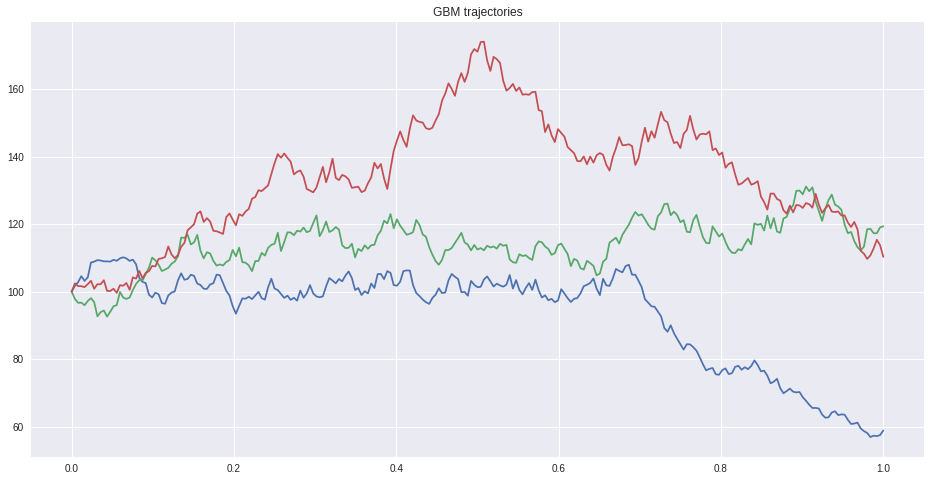

In [7]:
%matplotlib inline
N = 252
n = 1
St = gbm(S0 = 100, r = 0.01, sigma = 0.3, T = 1, time_steps=N, n_paths = 3)
t = np.linspace(0, 1, N+1)
fig = plt.figure(figsize=(16, 8))
plt.title("GBM trajectories")
_ = plt.plot(t, St)

### Wycena opcji

Do wyceny posłuzymy się biblioteką `mibian` (<a href="https://github.com/neilsmurphy/MibianLib">GitHub: MibianLib</a>).

Zawiera gotowe algorytmy waluacyjne dla waniliowych opcji europejskich. Dostaniemy z niej ceny i wartości greckich parametrów dla opcji call i put 

In [8]:
S0 = 150.0
K = 150.0
rfr = 1 # in pct
T = 365# in days
sigma = 40 # in pct
option = mibian.BS([S0, K, rfr, T], volatility = sigma)


print(f"""
Call 
-----
Price: {option.callPrice:.4f}
Delta: {option.callDelta:.4f}
Gamma: {option.gamma:.4f}
Theta: {option.callTheta:.4f}
Vega:  {option.vega:.4f}
Rho:   {option.callRho:.4f}
""")


Call 
-----
Price: 24.4132
Delta: 0.5890
Gamma: 0.0065
Theta: -0.0337
Vega:  0.5835
Rho:   0.6394



## Black-Scholes PDE
#### Czyli co wpływa na wartość <s>opcji</s> instrumentu pochodnego?

Rozważymy cenę akcji $S_t$ o dynamice zadanej geometrycznym ruchem Browna, oraz instrumentu pochodnego $V_t$ używającym $S_t$ jako instrument bazowy.

Teoria Blacka-Scholesa mówi, że przy założeniach braku arbitrażu i zupełności rynku dynamika dowolnej derywaty spełnia cząstkowe równanie różniczkowe:

$$dV = \sigma S \frac{\partial V}{\partial S}dW + \bigg( \mu S \frac{\partial V}{\partial S} + \frac{1}{2}\sigma^2 S^2 \frac{\partial^2 V}{\partial S^2} + \frac{\partial V}{\partial t} \bigg)dt$$.

Widzimy dwa źródła dynamiki ceny: deterministyczne ($dt$), oraz losowe ($dW$).

W szczególności, dla instrumentu bazowego:

$$ dS = \mu S dt + \sigma S dW $$

### $\Delta$ hedging

Rozpatrzmy wartość portfel $\Pi$, złożony z derywaty $V$, oraz $x$ jednostek instrumentu bazowego $S$. Na zmiany wartości portfela wpływają dwa składniki:

$$ d\Pi = dV - x dS$$.

Rozpisując $dV$ i $dS$:
$$ d\Pi =  \sigma S \frac{\partial V}{\partial S}dW + \bigg( \mu S \frac{\partial V}{\partial S} + \frac{1}{2}\sigma^2 S^2 \frac{\partial^2 V}{\partial S^2} + \frac{\partial V}{\partial t} \bigg)dt - x \bigg(\mu S dt + \sigma S dW  \bigg) $$



$$ d\Pi = \bigg(\mu S \frac{\partial V}{\partial S} + \frac{1}{2}\sigma^2 S^2 \frac{\partial^2 V}{\partial S^2} + \frac{\partial V}{\partial t} -x\mu S \bigg)dt + \bigg(\sigma S \frac{\partial V}{\partial S} - x \sigma S \bigg)dW $$

$$ d\Pi = \bigg(\mu S \bigg(\frac{\partial V}{\partial S} - x \bigg)+ \frac{1}{2}\sigma^2 S^2 \frac{\partial^2 V}{\partial S^2} + \frac{\partial V}{\partial t} \bigg)dt + \sigma S \bigg(\frac{\partial V}{\partial S} - x \bigg)dW $$

**Q: Czy istnieje jakaś "specjalna" wartość $x?$**

**Q: Co się przy niej dzieje z wartością portfela $\Pi?$**

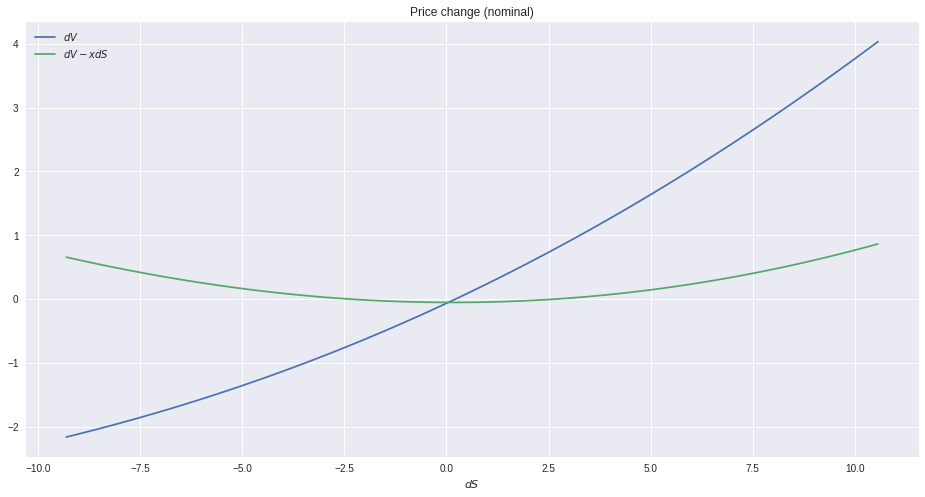

In [143]:
%matplotlib inline

# Numeric params setup
MC = 10000
dt = 5/365

# Market/Option params setup
r = 0.05
sig = 0.3
T = 1.
S0 = 70.
K = 90.
option = mibian.BS([S0, K, r*100, T*365], volatility = sig*100)

# Compute delta and price
delta = option.callDelta
V_0 = option.callPrice

# Simulate 1 day stock trajectory
S_1D = gbm(S0, r, sig, dt, 1, MC)[-1]

# Make an array of likely stock prices, based on min-max of the simulation.
# Compute option prices on that array.
S_1D = np.linspace(S_1D.min(), S_1D.max(), 100)
V_1D = np.array([mibian.BS([S, K, r*100, (T-dt)*365], volatility = sig*100).callPrice for S in S_1D])

# Compute price changes
DV_1D = V_1D - V_0*np.exp(r*dt)
DP_1D = (V_1D - delta*S_1D) - (V_0 - delta*S0)*np.exp(r*dt) 

# Plot changes of pure option vs portfolio
plt.figure(figsize=(16, 8))
plt.plot(S_1D - S0, DV_1D, label = '$dV$')
plt.plot(S_1D - S0, DP_1D, label = '$dV - xdS$')
plt.xlabel('$dS$')
plt.title('Price change (nominal)')
_ = plt.legend()

<div class="alert alert-block alert-info">
<b>Co tak właściwie się dzieje?</b>
    
$$ d\Pi = \bigg(\mu S \bigg(\frac{\partial V}{\partial S} - x \bigg)+ \frac{1}{2}\sigma^2 S^2 \frac{\partial^2 V}{\partial S^2} + \frac{\partial V}{\partial t} \bigg)dt + \sigma S \bigg(\frac{\partial V}{\partial S} - x \bigg)dW $$

Dobierając $x = \frac{\partial V}{\partial S}$ dostajemy dynamikę portfela:

$$ d\Pi = \bigg(\frac{1}{2}\sigma^2 S^2 \frac{\partial^2 V}{\partial S^2} + \frac{\partial V}{\partial t} \bigg)dt $$.   
</div>


A pisząc to samo po grecku:

Dobierając $x = \Delta$ dostajemy dynamikę portfela:

$$ d\Pi = \bigg(\frac{1}{2}\sigma^2 S^2 \Gamma + \Theta \bigg)dt $$

In [11]:
%matplotlib inline

@np.vectorize
def price_surface(S_, t_):
    return mibian.BS([S_, 90, 0.05*100, (T-t_)*365], volatility = 0.3*100).callPrice

@np.vectorize
def price_surface_delta_hedged(S_, t_):
    option = mibian.BS([S_, 90, 0.05*100, (T-t_)*365], volatility = 0.3*100).callPrice
    return option - delta*S_

S_lattice = np.linspace(S_1D.min(), S_1D.max(), 20)
t_lattice = np.linspace(0, dt, 20)

S, t = np.meshgrid(S_lattice, t_lattice)
V = price_surface(S, t)
Vh = price_surface_delta_hedged(S, t)

dV = V - V_0*np.exp(r*dt)
dVh = Vh - (V_0 - delta*S0)*np.exp(r*dt)

zmin, zmax = min(dVh.min(),dV.min()), max(dVh.max(), dV.max())

fig = go.Figure(data = [go.Surface(x=S-S0, y=t, z=dV, cmin=zmin, opacity=0.5, cmid=0.0, cmax = zmax, colorscale=colorscale),
                        go.Surface(x=S-S0, y=t, z=dVh, cmin=zmin, cmid=0.0, cmax = zmax, colorscale=colorscale)])
fig.update_layout(scene = dict(xaxis_title='dS',
                               yaxis_title='dt',
                               zaxis_title='dV'),
                autosize=False,
                margin=dict(l=0, r=0, b=0, t=50),
                title = "Unhedged vs Delta-hedged position")
fig.show()

### $\Delta-\Gamma$ hedging

Gammą instrumentu $V_t$ nazywamy $\Gamma := \frac{\partial^2 V}{\partial S^2}$. Jeżeli ta wartość również wyniesie zero, to portfel nazwiemy delta-gamma-neutralnym.

$$ d\Pi = \Big(\Theta +  \frac{1}{2}\sigma^2S^2\Gamma \Big)dt $$ 

$$ d\Pi = \Big(\Theta + 0 \Big)dt $$ 

Aby uzyskać portfel $\Delta$ neutralny musieliśmy posłużyć się innym, dodatkowym instrumentem finansowym. 
Okazuje się, że aby można uzyskać portfel jednocześnie $\Delta$ neutralny i $\Gamma$ neutralny ($\Delta-\Gamma$ neutralny), ale będziemy potrzebować do tego dwóch instrumentów.

Zajmiemy więc pozycję $x$ w akcji $S$, pozycję $y$ w opcji $C$, oraz sfinalizujemy to pozycją $z$ w obligacjach taką, żeby cały hedge był bezkosztowy:

$$ \Pi = V + x S + y C + z$$

$$ \Delta_{\Pi} = \Delta_{V} + x\Delta_{S} + y\Delta_{C} $$

$$ \Gamma_{\Pi} = \Gamma_{V} + x\Gamma_{S} + y\Gamma_{C} $$

Dobierzemy więc parę $(x, y)$ w sposób, który wyzeruje deltę i gammę pozycji. Aby je znaleźć rozwiązujemy układ równań:

$$\begin{bmatrix} \Delta_S & \Delta_C \\ \Gamma_S & \Gamma_C \end{bmatrix} \begin{bmatrix} x \\ y \end{bmatrix} = \begin{bmatrix} -\Delta_{V} \\ - \Gamma_{V} \end{bmatrix}$$.

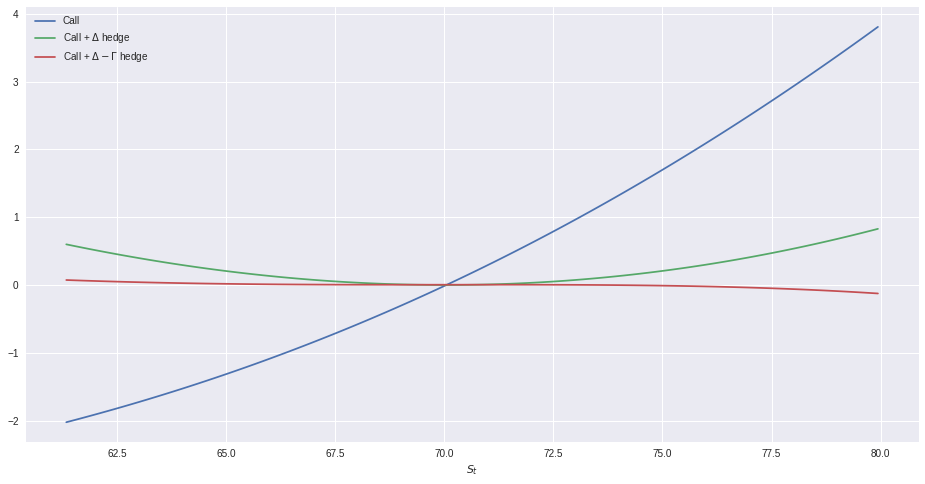

In [144]:
%matplotlib inline

# Setup two options
K1 = K
K2 = K1 + 30
option1 = mibian.BS([S0, K1, r*100, T*365], volatility = sig*100)
option2 = mibian.BS([S0, K2, r*100, T*365], volatility = sig*100)
options= [option1, option2]

# Calc their deltas, gammas and prices
deltas = [option.callDelta for option in options]
gammas = [option.gamma for option in options]
prices = [option.callPrice for option in options]

# Simulate 1D Stock prices, make an array covering their span and calculate option prices 
S_1D = gbm(S0, r, sig, dt, 1, MC)[-1]
S_1D = np.linspace(S_1D.min(), S_1D.max(), 100)
prices_1D = [np.array([mibian.BS([S, k, r*100, 364], volatility = sig*100).callPrice for S in S_1D]) for k in [K1, K2]]

# Solve the linear system for (x,y)
# AX = B
A = np.array([[1.0, deltas[1]], [0.0 , gammas[1]]]) # 1.0 and 0.0 are S(t) delta and gamma
B = np.array([[-deltas[0]], [-gammas[0]]])
x, y = np.linalg.solve(A, B) # positions in S(t) and second option

DV_1D = prices_1D[0] - prices[0]*np.exp(r*dt)
DH_1D = (prices_1D[0] - deltas[0]*S_1D) - (prices[0] - deltas[0]*S0)*np.exp(r*dt)
DGH_1D = (prices_1D[0] + x*S_1D + y*prices_1D[1]) - (prices[0] + x*S0 + y*prices[1])*np.exp(r*dt)

plt.figure(figsize=(16, 8))
plt.plot(S_1D, DV_1D, label = 'Call')
plt.plot(S_1D, DH_1D, label = 'Call + $\Delta$ hedge')
plt.plot(S_1D, DGH_1D, label = 'Call + $\Delta-\Gamma$ hedge')

plt.xlabel('$S_t$')

_ = plt.legend()

In [15]:
%matplotlib notebook

@np.vectorize
def price_surface(S_, t_):
    return mibian.BS([S_, 90, 0.05*100, (T-t_)*365], volatility = 0.3*100).callPrice

@np.vectorize
def price_surface_delta_gamma_hedged(S_, t_):
    option1 = mibian.BS([S_, K1, 0.05*100, (T-t_)*365], volatility = 0.3*100).callPrice
    option2 = mibian.BS([S_, K2, 0.05*100, (T-t_)*365], volatility = 0.3*100).callPrice
    return option1 + x*S_ + y*option2

S_lattice = np.linspace(S_1D.min(), S_1D.max(), 40)
t_lattice = np.linspace(0, dt, 20)

S, t = np.meshgrid(S_lattice, t_lattice)
V = price_surface(S, t)
Vdh = price_surface_delta_hedged(S, t)
Vdgh = price_surface_delta_gamma_hedged(S, t)

dV = V - prices[0]*np.exp(r*dt)
dVdh = Vdh - (prices[0] - delta*S0)*np.exp(r*dt)
dVdgh = Vdgh - (prices[0] + x*S0 + y*prices[1])*np.exp(r*dt)

zmin = min(dV.min(), dVdh.min(), dVdgh.min())
zmax = max(dV.max(), dVdh.max(), dVdgh.max())
zmid = (zmin + zmax)/2

fig = make_subplots(
    rows=1, cols=2,
    specs=[[{"type": "scene"}, {"type": "scene"}]],
)

fig.add_trace(go.Surface(x=S-S0, y=t, z=dV, cmin=zmin, cmid=.0, cmax = zmax, colorscale=colorscale), row=1, col=1)
fig.add_trace(go.Surface(x=S-S0, y=t, z=dVdh, cmin=zmin, cmid=.0, cmax = zmax, colorscale=colorscale), row=1, col=1)
fig.add_trace(go.Surface(x=S-S0, y=t, z=dVdgh, cmin=zmin, cmid=.0, cmax = zmax, colorscale=colorscale), row=1, col=1)

fig.add_trace(go.Surface(x=S-S0, y=t, z=dVdh, cmin=zmin, cmid=.0, cmax = zmax, colorscale=colorscale), row=1, col=2)
fig.add_trace(go.Surface(x=S-S0, y=t, z=dVdgh, cmin=zmin, cmid=.0, cmax = zmax, colorscale=colorscale), row=1, col=2)

fig.update_layout(scene = dict(xaxis_title='dS',
                               yaxis_title='dt',
                               zaxis_title='dV'),
                autosize=False,
                margin=dict(l=0, r=0, b=0, t=50),
                width =1200,
                title = "Delta-hedged vs Delta-gamma hedged position")

fig.show()

## Dynamic hedging

Do tej pory rozważaliśmy jednodniowy przyrost. Zobaczmy jednak co dzieje się z zahedgowaną pozycją jeśli będziemy ją utrzymywać przez dłuzszy okres czasu

### Parametry greckie

In [16]:
@np.vectorize
def option_delta(option_obj, option_type, S_, t_):
    S0 = option_obj.underlyingPrice
    K = option_obj.strikePrice
    sigma = option_obj.volatility
    r = option_obj.interestRate
    T = option_obj.daysToExpiration

    if option_type == "call":
      delta = mibian.BS([S_, K, r*100, (T-t_)*365], volatility = sigma*100).callDelta
    else:
      delta = mibian.BS([S_, K, r*100, (T-t_)*365], volatility = sigma*100).putDelta
    return delta

@np.vectorize
def option_gamma(option_obj, option_type, S_, t_):
    S0 = option_obj.underlyingPrice
    K = option_obj.strikePrice
    sigma = option_obj.volatility
    r = option_obj.interestRate
    T = option_obj.daysToExpiration
    gamma = mibian.BS([S_, K, r*100, (T-t_)*365], volatility = sigma*100).gamma
    return gamma
    
@np.vectorize
def option_theta(option_obj, option_type, S_, t_):
    S0 = option_obj.underlyingPrice
    K = option_obj.strikePrice
    sigma = option_obj.volatility
    r = option_obj.interestRate
    T = option_obj.daysToExpiration
    if option_type == "call":
      theta = mibian.BS([S_, K, r*100, (T-t_)*365], volatility = sigma*100).callTheta
    else:
      theta = mibian.BS([S_, K, r*100, (T-t_)*365], volatility = sigma*100).putTheta
    return theta
    
@np.vectorize
def option_vega(option_obj, option_type, S_, t_):
    S0 = option_obj.underlyingPrice
    K = option_obj.strikePrice
    sigma = option_obj.volatility
    r = option_obj.interestRate
    T = option_obj.daysToExpiration
    vega = mibian.BS([S_, K, r*100, (T-t_)*365], volatility = sigma*100).vega
    return vega


S0 = 100.
r = 0.05
sig = 0.3
T = 1.
K = 100

option = mibian.BS([S0, K, r*100, T*365], volatility = sigma)

S_lattice = np.linspace(S0*0.2, S0*1.7, 40)
t_lattice = np.linspace(0, T-0.01, 40)
S, t = np.meshgrid(S_lattice, t_lattice)
deltas = option_delta(option, "call", S, t)
gammas = option_gamma(option, "call", S, t)
thetas = option_theta(option, "call", S, t)
vegas = option_vega(option, "call", S, t)

In [17]:
app = JupyterDash(__name__)
height = 500
width = 500

deltas_figure = go.Figure(data=[go.Surface(x=S, y=t, z=deltas,
                                           colorscale='curl_r')])
gammas_figure = go.Figure(data=[go.Surface(x=S, y=t, z=gammas,
                                           colorscale='curl_r')])
thetas_figure = go.Figure(data=[go.Surface(x=S, y=t, z=thetas,
                                           colorscale='curl_r')]) #blackbody
vegas_figure = go.Figure(data=[go.Surface(x=S, y=t, z=vegas,
                                          colorscale='curl_r')])

deltas_figure.update_layout(autosize=False, width=width, height=height, title ="Delta",
                            margin={'t':40}, scene = dict(xaxis_title='UnderlyingPrice',
                                                          yaxis_title='TimeToExpiry',
                                                          zaxis_title='Delta'))

gammas_figure.update_layout(autosize=False, width=width, height=height, title ="Gamma",
                            margin={'t':40}, scene = dict(xaxis_title='UnderlyingPrice',
                                                          yaxis_title='TimeToExpiry',
                                                          zaxis_title='Gamma'))

thetas_figure.update_layout(autosize=False, width=width, height=height, title ="Theta",
                            margin={'t':40}, scene = dict(xaxis_title='UnderlyingPrice',
                                                          yaxis_title='TimeToExpiry',
                                                          zaxis_title='Theta'))

vegas_figure.update_layout(autosize=False, width=width, height=height, title = "Vega",
                            margin={'t':40}, scene = dict(xaxis_title='UnderlyingPrice',
                                                          yaxis_title='TimeToExpiry',
                                                          zaxis_title='Vega'))

app.layout = html.Div(
    children=[
        html.H2(
            "Call Greeks visualization "
        ),
        html.Div(
            [
                html.Div(
                    dcc.Graph(figure=deltas_figure),
                    style={"width": "49%", "display": "inline-block"},
                ),
                html.Div(
                    dcc.Graph(figure=gammas_figure),
                         style={"width": "49%", "display": "inline-block"},
                ),
            ]
        ),
        html.Div(
            [
                html.Div(
                    dcc.Graph(figure=thetas_figure),
                         style={"width": "49%", "display": "inline-block"},
                ),
                html.Div(
                    dcc.Graph(figure=vegas_figure),
                         style={"width": "49%", "display": "inline-block"},
                ),
            ]
        ),
    ]
)

app.run_server(
    mode="inline",
    port=8070,
    dev_tools_ui=True,
    debug=True,
    dev_tools_hot_reload=True,
    threaded=True,
)

<IPython.core.display.Javascript object>

Rozwiązaniem może być dynamiczne rebalansowanie pozycji - np. codziennie, co kilka dni, czy co tydzień etc.
Pojawia się tu inny problem, bo im częściej rebalansujemy tym większe koszty transakcji ponosimy. W praktyce należy dobrać pewien trade-off między częstością rebalansowania, a jego kosztami. 

Żeby doczytać więcej na ten temat sprawdź:
* [Ten artykuł](https://www.efmaefm.org/0efmameetings/efma%20annual%20meetings/2005-Milan/papers/284-zakamouline_paper.pdf) bazujący na funkcji użyteczności
* [Trochę nowocześniejsze podejście...](https://arxiv.org/pdf/1802.03042.pdf) używające RNN ...
* [... i jego kontynuacja](https://arxiv.org/pdf/2109.12337.pdf) porównująca modele liniowe, ML i CNN.

### Algorytm dynamicznego hedgingu

My założymy dla uproszczenia, że kosztów transakcji nie ma i skupimy się na mechanice dynamicznego rebalansowania pozycji.

Będziemy wykonywać następujące kroki:
1. Zadamy parametry opcji, oraz rynku
2. Wyliczymy deltę, gammę i pozycje hedgujące portfel
3. Dohedgujemy/odhedgujemy pozycję w sposób bezkosztowy
4. Wysymulujemy "krok" instrumentu bazowego
5. Obliczymy nową wartość portfela zgodnie z 2. i 3.
6. Wrócimy do punktu 2.

In [172]:
def dynamic_hedging(stock_trajectory, option_to_hedge, option_for_gamma):
    
    gbm_traj = stock_trajectory
    K = option_to_hedge.strikePrice
    r = option_to_hedge.interestRate
    T1 = option_to_hedge.daysToExpiration
    sig = option_to_hedge.volatility
    
    K2 = option_for_gamma.strikePrice
    T2 = option_for_gamma.daysToExpiration
    
    t_axis = np.linspace(0, T1, len(gbm_traj))
    dt = t_axis[1] - t_axis[0]


    Vt = []
    St = []
    Ct = []
    t=[]

    Strategies = {'DeltaHedge': {"t": [],
                                 "Value": [],
                                 "Stock": [],
                                 "MM": []},
                  'DeltaGammaHedge': {"t": [],
                                      "Value": [],
                                      "Stock": [],
                                      "Option": [],
                                      "MM":[]}
                 }
    for S, t_ in zip(gbm_traj[:-1], t_axis[:-1]):
        
        option_V = mibian.BS([S, K, r*100, (T1-t_)*365], volatility = sig*100)
        option_C = mibian.BS([S, K2, r*100, (T2-t_)*365], volatility = sig*100)
        
        V = option_V.callPrice
        C = option_C.callPrice
        S = S

        if t_ == 0:
            DH = 0.0 # current value of delta hedged portfolio "hedge" part
            DGH = 0.0 # current value of delta-gamma hedged portfolio "hedge" part
        else:
            DH = Strategies['DeltaHedge']['Stock'][-1]*S + Strategies['DeltaHedge']['MM'][-1]*np.exp(r*dt)
            DGH = Strategies['DeltaGammaHedge']['Stock'][-1]*S + Strategies['DeltaGammaHedge']['Option'][-1]*C + Strategies['DeltaGammaHedge']['MM'][-1]*np.exp(r*dt)

        Strategies['DeltaHedge']['Value'].append(DH)
        Strategies['DeltaGammaHedge']['Value'].append(DGH)

        Vt.append(V)
        St.append(S)
        Ct.append(C)
        t.append(t_)

        # Greeks
        delta_V = option_V.callDelta
        delta_C = option_C.callDelta
        delta_S = 1.0

        gamma_V = option_V.gamma
        gamma_C = option_C.gamma
        gamma_S = 0.0
        #Pdb().set_trace()

        # Delta hedging
        A = np.array([[delta_S, 0], [S, 1]])
        B = np.array([[delta_V], [DH]])
        X = np.linalg.solve(A, B)

        Strategies['DeltaHedge']['Stock'].append(X[0][0])
        Strategies['DeltaHedge']['MM'].append(X[1][0])

        #Delta-gamma hedging
        A = np.array([[delta_S, delta_C, 0], [gamma_S, gamma_C, 0], [S, C, 1]])
        B = np.array([[delta_V], [gamma_V], [DGH]])
        X = np.linalg.solve(A, B)

        Strategies['DeltaGammaHedge']['Stock'].append(X[0][0])
        Strategies['DeltaGammaHedge']['Option'].append(X[1][0])
        Strategies['DeltaGammaHedge']['MM'].append(X[2][0])


    t = np.array(t).reshape(-1, 1)
    Vt = np.array(Vt).reshape(-1, 1)
    Strategies['DeltaHedge']['Value'] = np.array(Strategies['DeltaHedge']['Value']).reshape(-1, 1)
    Strategies['DeltaGammaHedge']['Value'] = np.array(Strategies['DeltaGammaHedge']['Value']).reshape(-1, 1)
    
    return t, Vt, Strategies 

np.random.seed(126)
S0 = 60.
r = .05
sig = .3
T = 1.

gbm_traj = gbm(S0 = S0, r = r, sigma = sig, T = T, time_steps = 252, n_paths = 1).ravel()

option_to_hedge = mibian.BS([S0, 40., r*100, T*365], volatility = sig*100)
option_for_gamma = mibian.BS([S0, 45., r*100, T*365], volatility = sig*100)

t, Vt, Strategies = dynamic_hedging(gbm_traj, option_to_hedge = option_to_hedge, option_for_gamma = option_for_gamma)

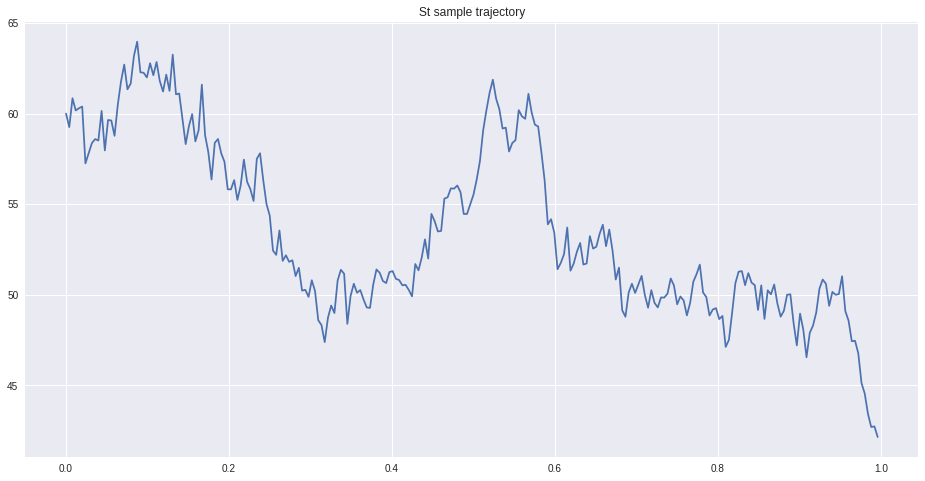

In [173]:
%matplotlib inline 
fig = plt.figure(figsize=(16, 8))
plt.plot(t, gbm_traj[:-1])
_ = plt.title("St sample trajectory")

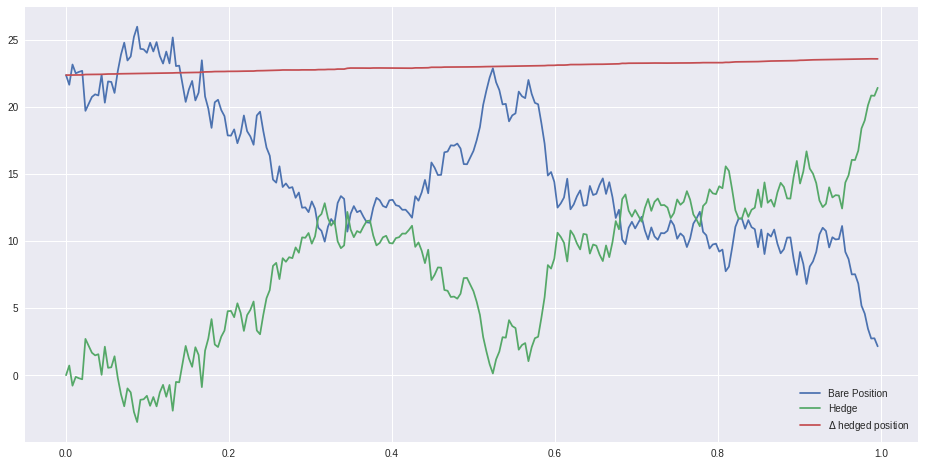

In [174]:
%matplotlib inline
fig = plt.figure(figsize=(16, 8))
plt.plot(t, Vt, label = 'Bare Position')
plt.plot(t, -Strategies['DeltaHedge']['Value'], label = "Hedge")
plt.plot(t, Vt-Strategies['DeltaHedge']['Value'], label = '$\Delta$ hedged position')

_ = plt.legend()

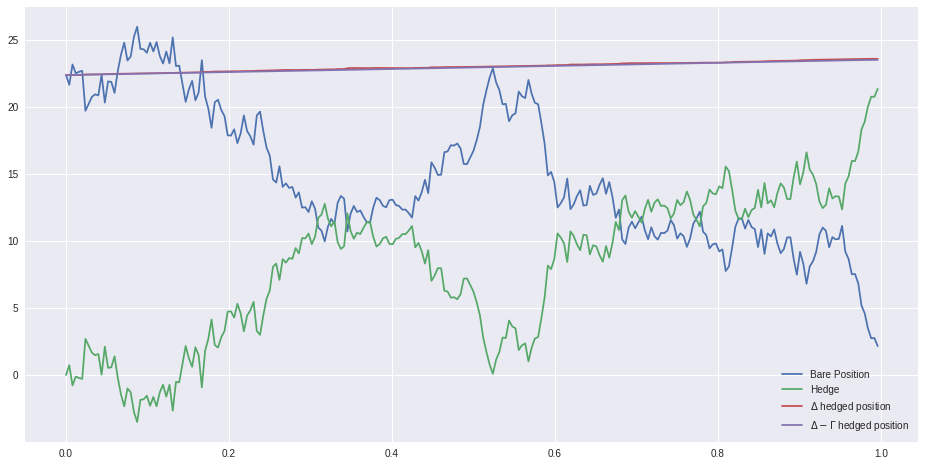

In [175]:
%matplotlib inline
fig = plt.figure(figsize=(16, 8))
plt.plot(t, Vt, label = 'Bare Position')
plt.plot(t, -Strategies['DeltaGammaHedge']['Value'], label = "Hedge")
plt.plot(t, Vt-Strategies['DeltaHedge']['Value'], label = '$\Delta$ hedged position')
plt.plot(t, Vt - Strategies['DeltaGammaHedge']['Value'], label = '$\Delta-\Gamma$ hedged position')
_ = plt.legend()

In [176]:
diff = (Vt[1:] - Strategies['DeltaGammaHedge']['Value'][1:])
np.log(diff[-1]/diff[0])

array([0.04909957])

### Przykład na danych rynkowych

In [224]:
ticker = "TWTR"
real_data = yf.download(ticker, start="2019-10-01", end="2020-10-01")['Open']
calibration_data = yf.download(ticker, start = "2018-10-01", end="2019-10-01")["Open"]

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


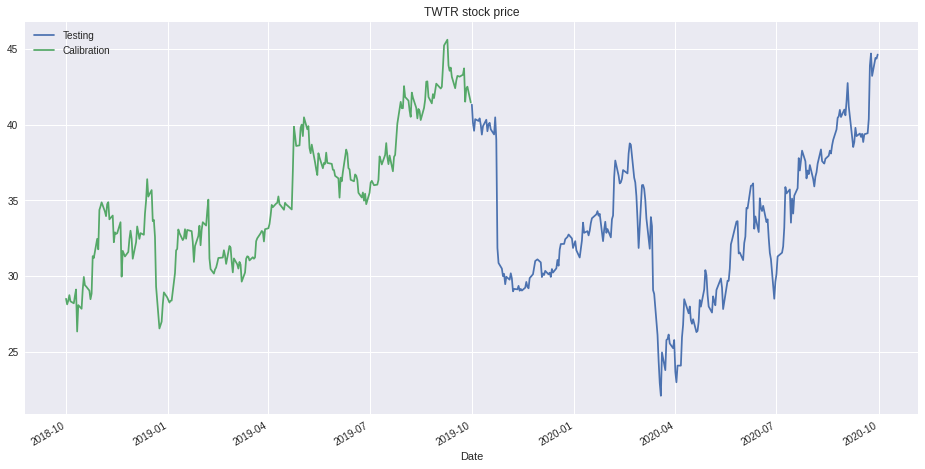

In [225]:
%matplotlib inline

fig = plt.figure(figsize = (16, 8))
real_data.plot(label="Testing")
calibration_data.plot(label="Calibration")

plt.legend()
_ = plt.title(f"{ticker} stock price")

In [227]:
S0 = real_data[0]
real_logrets = np.log(real_data).diff()
sig_hist = np.log(calibration_data).diff().std()*np.sqrt(365)
K = 35.
T = 1.
r = .05

t_real, Vt_real, Strategies_real = dynamic_hedging(real_data,
                                                   option_to_hedge = mibian.BS([S0, K, r*100, T*365], volatility = sig_hist*100),
                                                   option_for_gamma = mibian.BS([S0, K, r*100, 2*T*365], volatility = sig_hist*100))

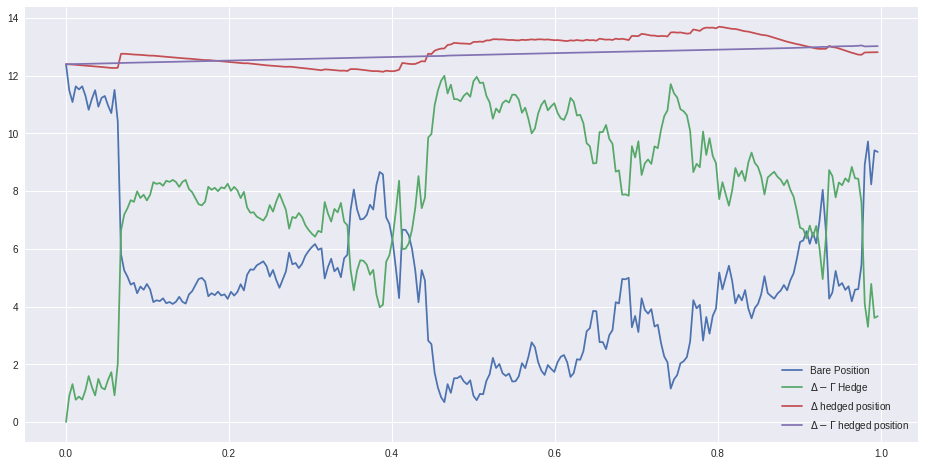

In [228]:
%matplotlib inline
fig = plt.figure(figsize=(16, 8))
plt.plot(t_real, Vt_real, label = 'Bare Position')
plt.plot(t_real, -Strategies_real['DeltaGammaHedge']['Value'], label = "$\Delta-\Gamma$ Hedge")
plt.plot(t_real, Vt_real-Strategies_real['DeltaHedge']['Value'], label = '$\Delta$ hedged position')
plt.plot(t_real, Vt_real - Strategies_real['DeltaGammaHedge']['Value'], label = '$\Delta-\Gamma$ hedged position')
_ = plt.legend()

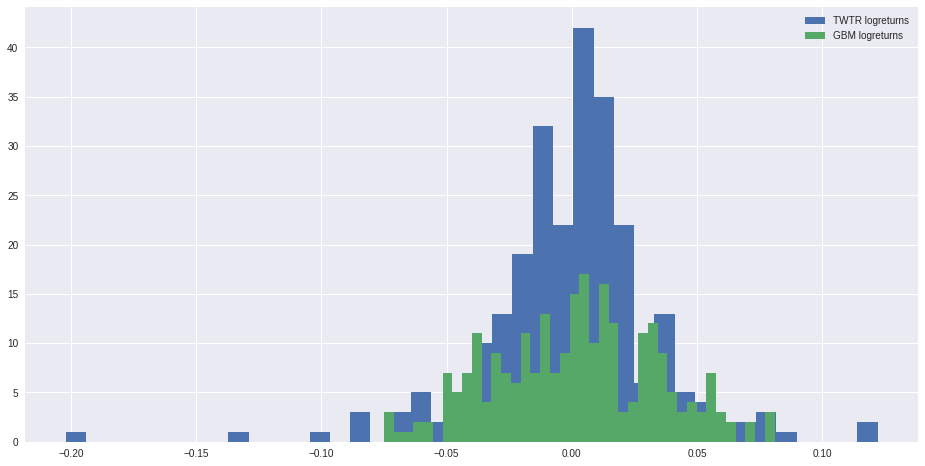

In [234]:
%matplotlib inline
real_data_np = np.array(real_data).reshape(-1, 1)
logrets_real = np.diff(np.log(real_data_np), axis = 0)
fig = plt.figure(figsize=(16, 8))
plt.hist(logrets_real, label = f'{ticker} logreturns', bins = 40)

gbm_traj = gbm(S0 = S0, r = r, sigma = sig_hist, T = T, time_steps = len(real_data_np), n_paths = 1).ravel()
logrets_gbm = np.diff(np.log(gbm_traj))
plt.hist(logrets_gbm, label = 'GBM logreturns', bins = 40)
_ = plt.legend()

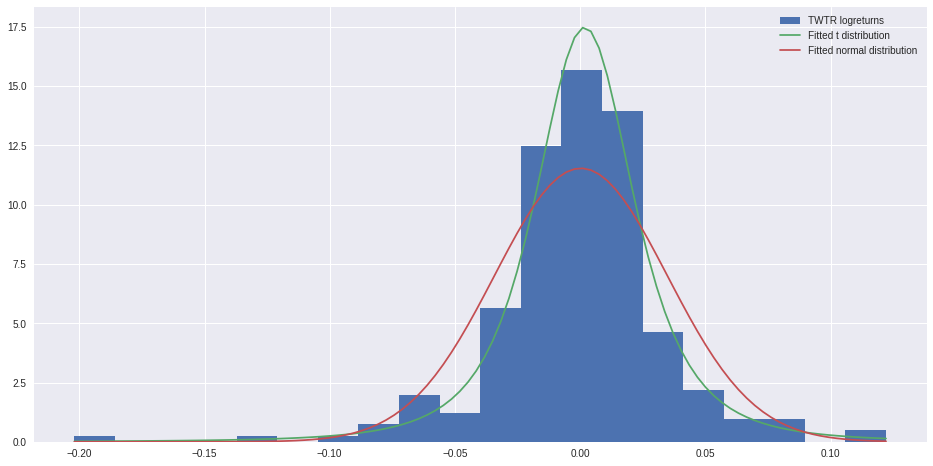

In [235]:
t_fitted = sc.t.fit(logrets_real)
t_fitted = sc.t(*t_fitted)

norm_fitted = sc.norm.fit(logrets_real)
norm_fitted = sc.norm(*norm_fitted)

cauchy_fitted = sc.cauchy.fit(logrets_real)
cauchy_fitted = sc.cauchy(*cauchy_fitted)

fig = plt.figure(figsize=(16, 8))
x_axis = np.linspace(logrets_real.min(), logrets_real.max(), 100)
_=plt.hist(logrets_real, label =f'{ticker} logreturns', bins = 20, density = True)
plt.plot(x_axis, t_fitted.pdf(x_axis), label = 'Fitted t distribution')
plt.plot(x_axis, norm_fitted.pdf(x_axis), label = 'Fitted normal distribution')
_= plt.legend()

## $\nu$ hedging

### BS PDE vs Taylor Series

Zamiast wychodzić z PDE Blacka-Scholesa zastanówmy się nad funkcją ceny pewnej derywaty $H(S, t, \sigma)$ i jej dynamiką wynikającą z (bardziej ogólnego niż BS PDE) rozwinięcia Taylora. 

\begin{equation}
\begin{split}
dH(S, t, \sigma)  & = \frac{\partial H}{\partial S}dS + \frac{\partial H}{\partial t}dt + \frac{\partial H}{\partial \sigma}d\sigma + \\
 & + \frac{1}{2} \frac{\partial^2 H}{\partial S^2}(dS)^2 + \frac{1}{2} \frac{\partial^2 H}{\partial t^2}(dt)^2 + \frac{1}{2} \frac{\partial^2 H}{\partial \sigma^2}(d\sigma)^2 + \frac{\partial^2 H}{\partial S \partial t}dSdt + \frac{\partial^2 H}{\partial S \partial \sigma}dSd\sigma + \frac{\partial^2 H}{\partial t \partial \sigma}dtd\sigma + \dots = \approx \\
& = \Delta dS - \Theta dt + \nu d\sigma + \\
& + \frac{1}{2}\Gamma dS^2 - \frac{1}{2}\frac{d\Theta_H}{dt}dt^2 + \frac{1}{2}\text{Vomma } d\sigma^2 + \\
& + \text{Charm }dSdt +  \text{Vanna } dSd\sigma + \text{Veta } dtd\sigma \approx \\
& \approx \Delta dS - \Theta dt + \nu d\sigma + \frac{1}{2}\Gamma \sigma^2 S^2 dt\\\\
\end{split}
\end{equation}


Wtedy dla portfela $\Pi$ złożonego z derywaty $V$ i trzech innych instrumentów ($D_1$, $D_2$, $D_3$) możemy rozpisać greckie parametry następująco:  

\begin{equation}
\begin{split}
\Pi(S, t, \sigma) &= V + xD_1 + yD_2 + zD_3 \\
\Delta_{\Pi} &= \Delta_V + x\Delta_{D_1} + y\Delta_{D_2} + z\Delta_{D_3} \\
\Gamma_{\Pi} &= \Gamma_V + x\Gamma_{D_1} + y\Gamma_{D_2} + z\Gamma_{D_3} \\
\nu_{\Pi} &= \nu_V + x\nu_{D_1} + y\nu_{D_2} + z\nu_{D_3}\\\\
\end{split}
\end{equation}
Do opcji $V$ będziemy dobierać pozycję w instrumencie bazowym $S$, i dwóch opcjach $C$ i $P$ aby stworzyć portfel $\Delta-\Gamma-\nu$-neutralny. Kolejny raz jest to problem liniowy:

$$\begin{bmatrix} \Delta_S & \Delta_C & \Delta_P \\ \Gamma_S & \Gamma_C & \Gamma_P \\ \nu_S & \nu_C & \nu_P \end{bmatrix} \begin{bmatrix} x \\ y \\ z \end{bmatrix} = \begin{bmatrix} -\Delta_{V} \\ - \Gamma_{V} \\ -\nu_V \end{bmatrix}$$.

In [308]:
%matplotlib inline

# Setup three options
K1 = 100.
K2 = 100.
K3 = 100. + 30
S0 = 100.
r = 0.05
T = 1.0
sig = 0.3

option1 = mibian.BS([S0, K1, r*100, T*365], volatility = sig*100)
option2 = mibian.BS([S0, K2, r*100, 2*T*365], volatility = sig*100)
option3 = mibian.BS([S0, K3, r*100, T*365], volatility = sig*100)
options= [option1, option2, option3]

# Calc their deltas, gammas, vegas and prices
deltas = [option.callDelta for option in options]
gammas = [option.gamma for option in options]
vegas = [option.vega for option in options]
prices = [option.callPrice for option in options]

# Make lattice for 3D plots
S_lattice = np.linspace(S0*0.8, S0*1.2, 40)
sigma_lattice = np.linspace(sig*0.8, sig*1.2, 40)
S_, sig_ = np.meshgrid(S_lattice, sigma_lattice)


# Compute delta-gamma and delta-gamma-vega neutral positions
@np.vectorize
def price_surface(S_, sigma_):
    option1 = mibian.BS([S_, K1, 0.05*100, (T-dt)*365], volatility = sigma_*100).callPrice
    return option1
V = price_surface(S_, sig_)
dV = V - prices[0]*np.exp(r*dt)

# Solve the linear system for (x,y)
# AX = B
A = np.array([[1.0, deltas[1]],
              [0.0, gammas[1]]])
B = np.array([[-deltas[0]],
              [-gammas[0]]])
x, y = np.linalg.solve(A, B) # positions in S(t), second and third option
@np.vectorize
def price_surface_delta_gamma_hedged(S_, sigma_):
    option1 = mibian.BS([S_, K1, 0.05*100, (T-dt)*365], volatility = sigma_*100).callPrice
    option2 = mibian.BS([S_, K2, 0.05*100, (2*T-dt)*365], volatility = sigma_*100).callPrice
    return option1 + x*S_ + y*option2
Vdgh = price_surface_delta_gamma_hedged(S_, sig_)
dVdgh = Vdgh - (prices[0] + x*S0 + y*prices[1])*np.exp(r*dt)


# Solve the linear system for (x,y)
# AX = B
A = np.array([[1.0, deltas[1], deltas[2]],
              [0.0, gammas[1], gammas[2]],
              [0.0, vegas[1],  vegas[2]]])
B = np.array([[-deltas[0]],
              [-gammas[0]],
              [-vegas[0]]])
x, y, z = np.linalg.solve(A, B) # positions in S(t), second and third option
@np.vectorize
def price_surface_delta_gamma_vega_hedged(S_, sigma_):
    option1 = mibian.BS([S_, K1, 0.05*100, (T-dt)*365], volatility = sigma_*100).callPrice
    option2 = mibian.BS([S_, K2, 0.05*100, (2*T-dt)*365], volatility = sigma_*100).callPrice
    option3 = mibian.BS([S_, K3, 0.05*100, (T-dt)*365], volatility = sigma_*100).callPrice
    return option1 + x*S_ + y*option2 + z*option3
Vdgvh = price_surface_delta_gamma_vega_hedged(S_, sig_)
dVdgvh = Vdgvh - (prices[0] + x*S0 + y*prices[1] + z*prices[2])*np.exp(r*dt)


zmin = min(dV.min(), dVdgh.min(), dVdgvh.min())
zmax = max(dV.max(), dVdgh.max(), dVdgvh.max())
zmid = (zmin + zmax)/2


app = JupyterDash(__name__)
height = 500
width = 500

unhedged_figure = go.Figure(data=[go.Surface(x=S_, y=sig_, z=V,
                                             cmin=zmin, cmid=.0, cmax = zmax,
                                             colorscale=colorscale)])

hedged = go.Figure(data=[go.Surface(x=S_, y=sig_, z=dV,
                                    cmin=zmin, cmid=.0, cmax = zmax,
                                    colorscale='curl_r',
                                    name = "Unhedged"),
                         go.Surface(x=S_, y=sig_, z=dVdgh,
                                    cmin=zmin, cmid=.0, cmax = zmax,
                                    colorscale='curl_r',
                                    name = "DeltaGamma"),
                         go.Surface(x=S_, y=sig_, z=dVdgvh,
                                    cmin=zmin, cmid=.0, cmax = zmax,
                                    colorscale='curl_r',
                                    name="DeltaGammaVega")])

unhedged_figure.update_layout(autosize=False, width=width, height=height, title ="Unhedged",
                            margin={'t':40}, scene = dict(xaxis_title='UnderlyingPrice',
                                                          yaxis_title='ImpliedVol',
                                                          zaxis_title='CallPrice'))

hedged.update_layout(autosize=False, width=width, height=height, title ="Hedged",
                            margin={'t':40}, scene = dict(xaxis_title='UnderlyingPrice',
                                                          yaxis_title='ImpliedVol',
                                                          zaxis_title='CallPrice'))

app.layout = html.Div(
    children=[
        html.H2(
            "Delta-gamma-vega hedge"
        ),
        html.Div(
            [
                html.Div(
                    dcc.Graph(figure=unhedged_figure),
                    style={"width": "49%", "display": "inline-block"},
                ),
                html.Div(
                    dcc.Graph(figure=hedged),
                         style={"width": "49%", "display": "inline-block"},
                ),
            ]
        )
    ]
)

app.run_server(
    mode="inline",
    port=8070,
    dev_tools_ui=True,
    debug=True,
    dev_tools_hot_reload=True,
    threaded=True,
)

<IPython.core.display.Javascript object>